# Import data

In [1]:
RANDOM_SEED = 1

In [2]:
SET_FIT_INTERCEPT = True

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor,BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_log_error

import csv

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
whole = pd.concat([train,test], axis = 0, sort=True)

In [5]:
train.shape

(10886, 12)

In [6]:
test.shape

(6493, 9)

In [7]:
whole.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


In [402]:
whole.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 6492
Data columns (total 12 columns):
atemp         17379 non-null float64
casual        10886 non-null float64
count         10886 non-null float64
datetime      17379 non-null object
holiday       17379 non-null int64
humidity      17379 non-null int64
registered    10886 non-null float64
season        17379 non-null int64
temp          17379 non-null float64
weather       17379 non-null int64
windspeed     17379 non-null float64
workingday    17379 non-null int64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.7+ MB


# Handle Time

In [8]:
whole['datetime'] = pd.to_datetime(whole['datetime'])

In [9]:
whole['hour'] = whole['datetime'].dt.hour

In [10]:
whole['day'] = whole['datetime'].dt.day

In [11]:
whole['year'] = whole['datetime'].dt.year

In [12]:
whole = whole[['datetime','season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','day','year','count']]

In [13]:
#correlation heatmap for seaborn
def corr_chart(df_corr):
    corr = df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm',
                center = 0, square = True, 
                linewidth = 0.5, cbar_kws={'shrink': .5},
                annot = True, annot_kws = {'size': 9}, fmt = '.3f')
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 0)
    plt.title('Correlation Heatmap')
    plt.savefig('plt-corr-heatmap.pdf',
                bbox_inches = 'tight', dpi = None, facecolor = 'w', edgecolor = 'b',
                orientation = 'portrait', papertype = None, format = None, 
                transparent = True, pad_inches = 0.5, frameon = None)
    
np.set_printoptions(precision = 3)

In [14]:
corr_matrix =whole.corr()

In [15]:
print(corr_matrix["count"].sort_values(ascending=False))

count         1.000000
hour          0.400601
temp          0.394454
atemp         0.389784
year          0.260403
season        0.163439
windspeed     0.101369
day           0.019826
workingday    0.011594
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64


C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


<Figure size 432x288 with 0 Axes>

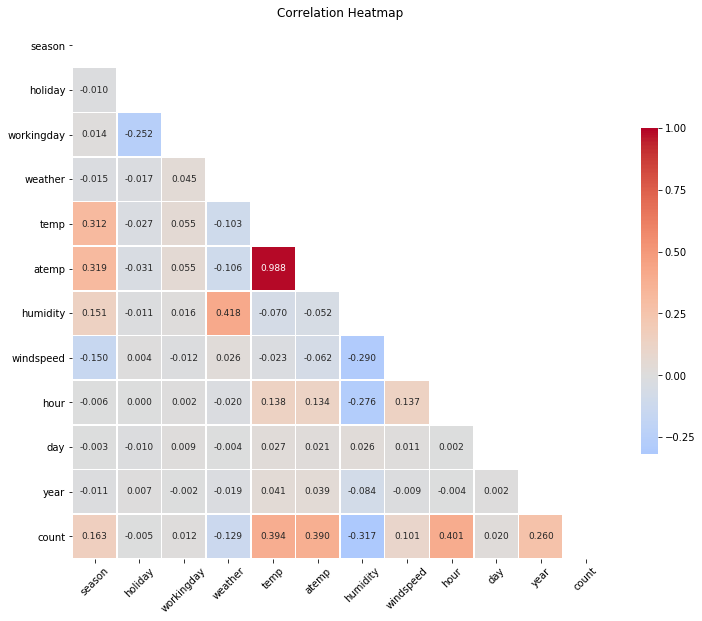

In [16]:
corr_chart(df_corr = whole)

# Looking into the Data

## Counts

<BarContainer object of 822 artists>

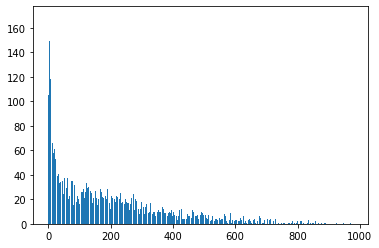

In [16]:
plt.bar(whole['count'].value_counts().index, whole['count'].value_counts())

<BarContainer object of 822 artists>

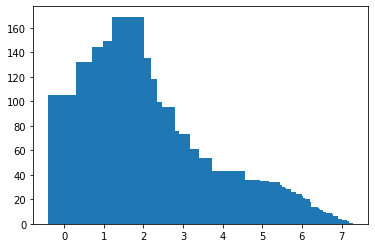

In [17]:
plt.bar(np.log(whole['count']).value_counts().index, np.log(whole['count']).value_counts())

In [18]:
whole.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,year,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,0,1,2011,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,1,1,2011,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,2,1,2011,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,1,2011,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,4,1,2011,1.0


### season

In [19]:
groupby_train = train.groupby(['season']).sum()['count']

Text(0.5, 1.0, 'numbers of data points')

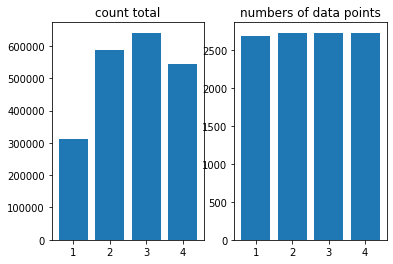

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.bar(groupby_train.index.values, groupby_train)
ax1.set_title('count total')

ax2.bar(train.season.value_counts().index, train.season.value_counts())
ax2.set_title('numbers of data points')

### Wind Speed

Text(0.5, 1.0, 'numbers of data points')

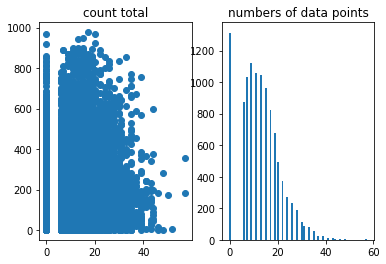

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.scatter(train['windspeed'],train['count'])
ax1.set_title('count total')

ax2.bar(train.windspeed.value_counts().index, train.windspeed.value_counts())
ax2.set_title('numbers of data points')

### weather

Text(0.5, 1.0, 'numbers of data points')

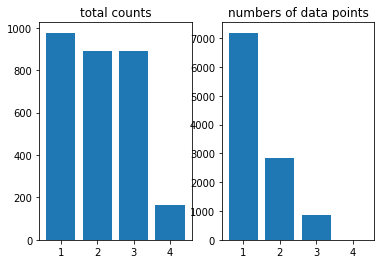

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.bar(train['weather'],train['count'])
ax1.set_title('total counts')

ax2.bar(train.weather.value_counts().index, train.weather.value_counts())
ax2.set_title('numbers of data points')

### Working Day

Text(0.5, 1.0, 'numbers of data points')

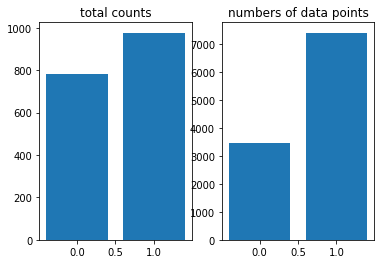

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.bar(train['workingday'],train['count'])
ax1.set_title('total counts')

ax2.bar(train.workingday.value_counts().index, train.workingday.value_counts())
ax2.set_title('numbers of data points')

Fewer people use bikes on working days

### holiday

Text(0.5, 1.0, 'numbers of data points')

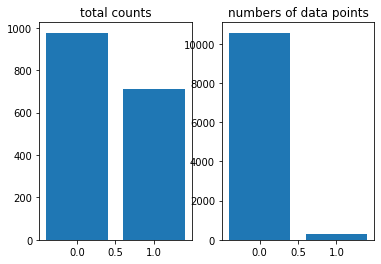

In [27]:
fig ,(ax1, ax2) = plt.subplots(1,2)

ax1.bar(train['holiday'],train['count'])
ax1.set_title('total counts')

ax2.bar(train.holiday.value_counts().index, train.holiday.value_counts())
ax2.set_title('numbers of data points')

### Temperature

Text(0.5, 1.0, 'numbers of data points')

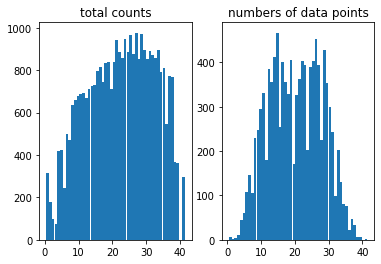

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.bar(train['temp'],train['count'])
ax1.set_title('total counts')

ax2.bar(train.temp.value_counts().index, train.temp.value_counts())
ax2.set_title('numbers of data points')

### atemp

Text(0.5, 1.0, 'numbers of data points')

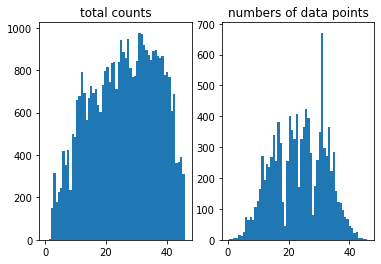

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.bar(train['atemp'],train['count'])
ax1.set_title('total counts')

ax2.bar(train.atemp.value_counts().index, train.atemp.value_counts())
ax2.set_title('numbers of data points')

### humidity

Text(0.5, 1.0, 'numbers of data points')

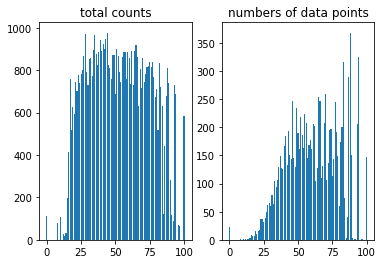

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.bar(train['humidity'],train['count'])
ax1.set_title('total counts')

ax2.bar(train.humidity.value_counts().index, train.humidity.value_counts())
ax2.set_title('numbers of data points')

# Encode Categories

In [17]:
model_data = whole
categories = ['season','holiday','workingday','weather','hour','day','year']
le = LabelEncoder()
model_data[categories] = model_data[categories].apply(lambda col: le.fit_transform(col))

In [18]:
model_data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'hour', 'day', 'year', 'count'],
      dtype='object')

In [19]:
model_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,year,count
0,2011-01-01 00:00:00,0,0,0,0,9.84,14.395,81,0.0,0,0,0,16.0
1,2011-01-01 01:00:00,0,0,0,0,9.02,13.635,80,0.0,1,0,0,40.0
2,2011-01-01 02:00:00,0,0,0,0,9.02,13.635,80,0.0,2,0,0,32.0
3,2011-01-01 03:00:00,0,0,0,0,9.84,14.395,75,0.0,3,0,0,13.0
4,2011-01-01 04:00:00,0,0,0,0,9.84,14.395,75,0.0,4,0,0,1.0


In [20]:
model_data['log'] = np.log(model_data['count'])

In [21]:
model_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,year,count,log
0,2011-01-01 00:00:00,0,0,0,0,9.84,14.395,81,0.0,0,0,0,16.0,2.772589
1,2011-01-01 01:00:00,0,0,0,0,9.02,13.635,80,0.0,1,0,0,40.0,3.688879
2,2011-01-01 02:00:00,0,0,0,0,9.02,13.635,80,0.0,2,0,0,32.0,3.465736
3,2011-01-01 03:00:00,0,0,0,0,9.84,14.395,75,0.0,3,0,0,13.0,2.564949
4,2011-01-01 04:00:00,0,0,0,0,9.84,14.395,75,0.0,4,0,0,1.0,0.000000


In [22]:
model_data.shape

(17379, 14)

In [23]:
model_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,year,count,log
0,2011-01-01 00:00:00,0,0,0,0,9.84,14.395,81,0.0,0,0,0,16.0,2.772589
1,2011-01-01 01:00:00,0,0,0,0,9.02,13.635,80,0.0,1,0,0,40.0,3.688879
2,2011-01-01 02:00:00,0,0,0,0,9.02,13.635,80,0.0,2,0,0,32.0,3.465736
3,2011-01-01 03:00:00,0,0,0,0,9.84,14.395,75,0.0,3,0,0,13.0,2.564949
4,2011-01-01 04:00:00,0,0,0,0,9.84,14.395,75,0.0,4,0,0,1.0,0.000000


# Train test split

In [24]:
train = model_data.loc[model_data['count'].isna()==False]
test = model_data.loc[model_data['count'].isna()]

In [25]:
X = train.iloc[:,1:12]
y = train.iloc[:,[-1]]
test_X = test.iloc[:,1:12]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8708, 11)
(2178, 11)
(8708, 1)
(2178, 1)


# Building Models

### Trying different regressors

In [28]:
model_names = ['Linear_Regression', 'Ridge_Regression', 'Lasso_Regression', 
         'ElasticNet_Regression', 
         'Random_Forest_Regression',
         'SVR', 
         'AdaBoost', 
         'Bagging', 
         'KNeighbors'] 


## GridSearchCV 

In [502]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50,100,250,500,1000], 'max_depth': [5,8,15,25,30], 
     'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1,2,5,10]}
]

rf_reg = RandomForestRegressor(random_state=RANDOM_SEED)
grid_search = GridSearchCV(rf_reg, param_grid, cv=5, scoring='neg_mean_squared_log_error', return_train_score=True)
grid_search.fit(X_train, y_train)

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was pa

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_depth': [5, 8, 15, 25, 30],


In [503]:
grid_search.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1000}

In [504]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [29]:
models = [LinearRegression(fit_intercept = SET_FIT_INTERCEPT), 
              Ridge(alpha = 1, solver = 'cholesky', 
                    fit_intercept = SET_FIT_INTERCEPT, 
                    normalize = False, 
                    random_state = RANDOM_SEED),               
              Lasso(alpha = 0.1, max_iter=1000, tol=0.0001, 
                    fit_intercept = SET_FIT_INTERCEPT, 
                    random_state = RANDOM_SEED),
              ElasticNet(alpha = 0.1, l1_ratio = 0.5, 
                         max_iter=10000, tol=0.01, 
                         fit_intercept = SET_FIT_INTERCEPT, 
                         normalize = False, 
                         random_state = RANDOM_SEED),
              RandomForestRegressor(n_estimators = 1000,
                                    criterion = 'mse', 
                                    max_depth = 30, 
                                    min_samples_split = 10, 
                                    min_samples_leaf = 1, 
                                    min_weight_fraction_leaf = 0.0, 
                                    max_features = None, 
                                    max_leaf_nodes = None, 
                                    min_impurity_split = 0.0, 
                                    bootstrap = True, 
                                    oob_score = False, 
                                    n_jobs = None, 
                                    random_state = 1, 
                                    verbose = 0, 
                                    warm_start = False),
                SVR(gamma = 'auto'), 
                AdaBoostRegressor(), 
                BaggingRegressor(bootstrap=True, n_jobs=-1, random_state = RANDOM_SEED), 
                KNeighborsRegressor()
            ]

In [30]:
model_loss = []
for m in range(len(models)):
    print(model_names[m])
    model = models[m]
    model.fit(X_train, y_train)
    predicted_y_test = model.predict(X_test)
    
    loss = np.sqrt(mean_squared_log_error(np.exp(y_test), np.exp(predicted_y_test)))
    model_loss.append([model_names[m], loss])

Linear_Regression
Ridge_Regression
Lasso_Regression
ElasticNet_Regression
Random_Forest_Regression


C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


SVR


C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost


C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Bagging


C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:398: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


KNeighbors


In [31]:
model_loss

[['Linear_Regression', 1.0193240756166368],
 ['Ridge_Regression', 1.0193187878955585],
 ['Lasso_Regression', 1.0374976368386288],
 ['ElasticNet_Regression', 1.025711884773397],
 ['Random_Forest_Regression', 0.3250213402975781],
 ['SVR', 0.9350687971970204],
 ['AdaBoost', 0.6574189045344022],
 ['Bagging', 0.34418110152121023],
 ['KNeighbors', 0.8675038161030402]]

# Random Forrest_Regression

In [32]:
model =  RandomForestRegressor(n_estimators = 1000,
                                    criterion = 'mse', 
                                    max_depth = 30, 
                                    min_samples_split = 10, 
                                    min_samples_leaf = 1, 
                                    min_weight_fraction_leaf = 0.0, 
                                    max_features = None, 
                                    max_leaf_nodes = None, 
                                    min_impurity_split = 0.0, 
                                    bootstrap = True, 
                                    oob_score = False, 
                                    n_jobs = None, 
                                    random_state = RANDOM_SEED, 
                                    verbose = 0, 
                                    warm_start = False)
model.fit(X,y)
predicted_ylog = model.predict(test_X)

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [33]:
predicted_y = np.exp(predicted_ylog)

In [34]:
predicted_y = predicted_y.astype('int32')

In [35]:
loss = model_loss[4][1]

## Write to CSV

In [36]:
lines = [['datetime', 'count']]
for i, j in enumerate(predicted_y):
    lines.append([test.iloc[i, 0], j])
    
with open('RMSLE = ' + str(loss) +'.csv', 'w') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerows(lines)
        
writeFile.close()